<a href="https://colab.research.google.com/github/zwickidtek/Tensors/blob/main/Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).


For now, we'll use this workflow to predict a simple straight line but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:
Topic 	Contents
1. Getting data ready 	Data can be almost anything but to get started we're going to create a simple straight line
2. Building a model 	Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
3. Fitting the model to data (training) 	We've got data and a model, now let's let the model (try to) find patterns in the (training) data.
4. Making predictions and evaluating a model (inference) 	Our model's found patterns in the data, let's compare its findings to the actual (testing) data.
5. Saving and loading a model 	You may want to use your model elsewhere, or come back to it later, here we'll cover that.
6. Putting it all together 	Let's take all of the above and combine it.

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

Machine learning is a game of two parts:

*     Turn your data, whatever it is, into numbers (a representation).
*     Pick or build a model to learn the representation as best as possible.

Sometimes one and two can be done at the same time.

But what if you don't have data?

Well, that's where we're at now.

No data.

But we can create some.

Let's create our data as a straight line.

In [3]:
# 'Known' Parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias

X[:10], Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Beautiful! Now we're going to move towards building a model that can learn the relationship between X (features) and y (labels).


### First we've got to split our data into training, and test set.

*     Training set - data models learns from ( 60-80% )
*     Testing set - data model gets evaluated on (10-20% )
*     Validation set - data model gets fine tuned on ( 10-20% )

In [4]:
# We can create training and test set by splitting our X and Y tensors

# We want our model to learn on training data and then evaluate it on test data to get an indication of how well it generalizes to unseen examples.


train_split = int(0.8*len(X)) # 80% of data
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

len(X_train), len(Y_train), len(X_test), len(Y_test)

(40, 40, 10, 10)



Wonderful, we've got 40 samples for training (X_train & y_train) and 10 samples for testing (X_test & y_test).

The model we create is going to try and learn the relationship between X_train & y_train and then we will evaluate what it learns on X_test and y_test.

But right now our data is just numbers on a page.

Let's create a function to visualize it.


In [7]:
def plot_predictions(train_data=X_train, 
                     train_labels=Y_train, 
                     test_data=X_test, 
                     test_labels=Y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

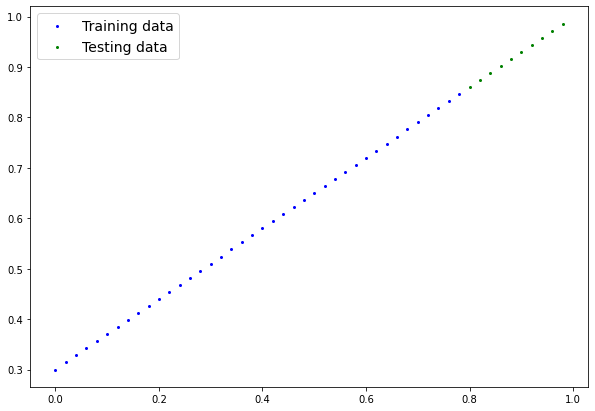

In [8]:
plot_predictions()

### BUILDING THE MODEL


 Now that we've got some data, lets build a model to use the buile dots to predict the green dots with a Linear Regression Module
 

In [10]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1, # <- start with random weights (this will get adjusted as the model learns)
                                           requires_grad=True,  # <- can we update this value with gradient descent?
                                           dtype=torch.float))  # <- PyTorch loves float32 by default
    self.bias = nn.Parameter(torch.rand(1, # <- start with random bias (this will get adjusted as the model learns)
                                        requires_grad=True, 
                                        dtype=torch.float))
    

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
      return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are torch.nn, torch.optim, torch.utils.data.Dataset and torch.utils.data.DataLoader. For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

*     torch.nn 	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
*     torch.nn.Parameter 	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
*     torch.nn.Module 	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.

In [11]:

# Checking the contents of a PyTorch model

# Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using .parameters().

# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())


[Parameter containing:
 tensor([0.8823], requires_grad=True), Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [12]:


# We can also get the state (what the model contains) of the model using .state_dict().

# List named parameters 
model_0.state_dict()


OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

Notice how the values for weights and bias from model_0.state_dict() come out as random float tensors?

This is becuase we initialized them above using torch.randn().

 it'll have poor predictive power

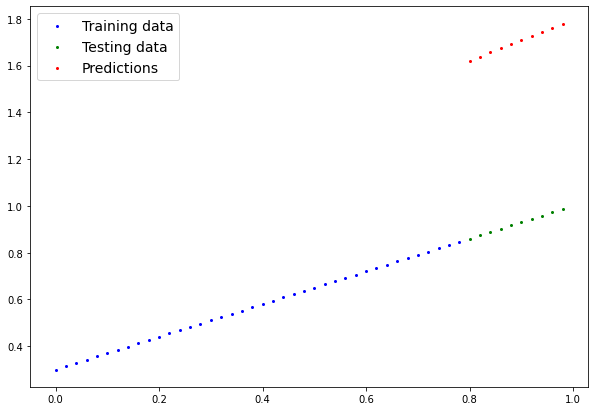

In [14]:

### Making predictions using torch.inference_mode()

# To check this we can pass it the test data X_test to see how closely it predicts y_test.

#When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)



Woah! Those predictions look pretty bad...

This make sense though when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

Time to change that.


Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

The rolls of these are:
* Loss function 	Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better. 	PyTorch has plenty of built-in loss functions in torch.nn. 	Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()).
* Optimizer 	Tells your model how to update its internal parameters to best lower the loss. 	You can find various optimization function implementations in torch.optim. 	Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).

In [15]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss (used for regression problems)

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize (SGD is stochastic gradient descent and is a popular optimizer along with adam)
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a training loop (and testing loop).

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

In [23]:
torch.manual_seed(42)
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    Y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(Y_pred, Y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, Y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")



Epoch: 0 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 10 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 20 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 30 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 40 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 50 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 60 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 70 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 80 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 
Epoch: 90 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 


In [24]:
print(model_0.state_dict())
print(f'Weights: {weight} Bias: {bias}')

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])
Weights: 0.7 Bias: 0.3


### MAKING PREDICTIONS WITH A TRAINED MODEL 
There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

    Set the model in evaluation mode (model.eval()).
    Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
    All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only)

In [25]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

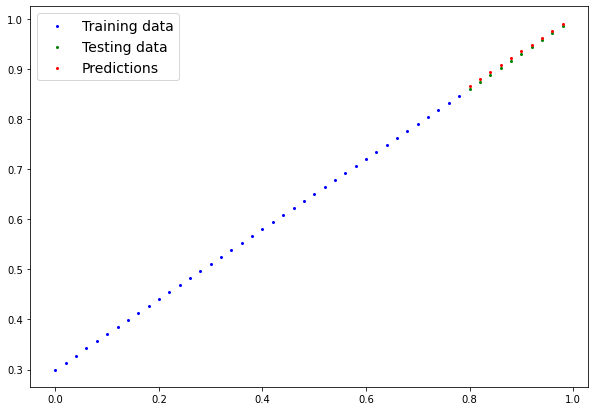

In [26]:
plot_predictions(predictions=y_preds)


### 5. Saving and loading a PyTorch model¶

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the PyTorch saving and loading models guide):
*    torch.save 	Saves a serialzed object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
*    torch.load 	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
*    torch.nn.Module.load_state_dict 	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [27]:

# We're happy with our model so let's save it somewhere
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_1.pth
